<div align="center">
<b>PhD Dissertation Report</b>
<br><br>
David Noel<br>
Nova Southeastern University<br>
CISD 901: Doctoral Dissertation<br><br>
May, 2023
<br>
<br>
<b>Committee:</b> Dr. Sumitra Mukherjee (Chair), Dr. Michael Laszlo, Dr. Frank Mitropoulos
</div>

# Analysis of Spatial Invariance in Convolutional Neural Networks

1.	Does data augmentation lead to more spatially invariant and robust networks?
2.	Are deep architectures more spatially invariant than wide architectures? Did a particular architecture perform better?
3.	Does generative data augmentation lead to more diverse samples than reinforcement learning techniques? Policy 2 vs. Policy 3.
4.	Do larger datasets increase spatial invariance? (Policy 2,4,5 vs. Policy 1 and 3)
5.	Do stacking data augmentation methods lead to more robust networks? Policy 5.
6.	Does combining synthesized samples with original unaugmented samples improve invariance in CNNs? Policy 4
7.	Do synthesized samples improve invariance? Policy 3
8.	Do Stochastic techniques based on Reinforcement learning techniques improve invariance? Policy 2
9.	Does the number of parameters in a CNN affect its spatial invariance as measured by its test accuracy?


# Imports

In [207]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
from pathlib import Path
import datetime
import os
import glob

# Hyperparameters

In [208]:
DATASET = "mnist" # "cifar10", "mnist", "fmnist
NETWORK = "basic"  # "resnet", "inception", "basic"
FOLDER = "." + os.sep + DATASET + os.sep + NETWORK
HISTORY_FILE = FOLDER + os.sep + f'{DATASET}_{NETWORK}_history.csv'
METRICS_FILE = FOLDER + os.sep + f'{DATASET}_{NETWORK}_metrics.csv'
NUMBER_POLICIES = 5
NETWORK_TITLE = "ResNet-50" if NETWORK == "resnet" else "InceptionV3" if NETWORK == "inception" else "the Base Model"
DATASET_TITLE = DATASET.upper()
NUM_EXPERIMENTS = 45

In [209]:
assert DATASET in ["cifar10", "mnist", "fmnist"], "DATASET must be cifar10, mnist or fmnist"
assert NETWORK in ["resnet", "inception", "basic"], "NETWORK must be resnet, inception, or basic"

# Load history and metrics

#### History summary

In [210]:
history = pd.read_csv(HISTORY_FILE)
print("Total records:", len(history))
history.head()

Total records: 384


,loss,accuracy,val_loss,val_accuracy,lr,policy
0,0.456237,0.862704,1.816092,0.381167,0.001,1
1,0.109712,0.966389,1.661344,0.451333,0.001,1
2,0.076705,0.976815,0.890344,0.713167,0.001,1
3,0.063196,0.980926,0.278995,0.901333,0.001,1
4,0.052374,0.983481,0.049283,0.984667,0.001,1


#### Metrics summary

In [211]:
# Combine all metrics files into pandas dataframe
all_metric_files = Path("./").rglob('*metrics.csv')
metrics = pd.concat((pd.read_csv(f) for f in all_metric_files), ignore_index=True)
assert len(metrics) == NUM_EXPERIMENTS, "Number of experiments must be 45"
metrics.head()

,dataset,model,params,policy,accuracy,precision,recall,f1score,latency
0,cifar10,basic,1091594,1,0.8516,0.851685,0.8516,0.850946,646.675142
1,cifar10,basic,1091594,2,0.8895,0.891337,0.8895,0.890070,1076.573843
2,cifar10,basic,1091594,3,0.1009,0.020891,0.1009,0.022837,397.216125
3,cifar10,basic,1091594,4,0.8072,0.812422,0.8072,0.808462,918.524923
4,cifar10,basic,1091594,5,0.6422,0.658380,0.6422,0.646462,641.519050


#### Dataset and Network Summary

In [212]:
df = metrics.where((metrics['dataset'] == DATASET) & (metrics['model']==NETWORK)).dropna()
df['policy'] = df['policy'].astype(int)
df

,dataset,model,params,policy,accuracy,precision,recall,f1score,latency
30,mnist,basic,1091594.0,1,0.9943,0.994382,0.994166,0.994266,350.438240
31,mnist,basic,1091594.0,2,0.9961,0.996123,0.996065,0.996091,947.715536
32,mnist,basic,1091594.0,3,0.9894,0.989419,0.989371,0.989387,557.723637
33,mnist,basic,1091594.0,4,0.9944,0.994377,0.994343,0.994353,955.326733
34,mnist,basic,1091594.0,5,0.9913,0.991491,0.991283,0.991359,934.653590


#### Percent improvement

In [213]:
# compute percentate change in accuracy relative to baseline
df['delta(%)'] = df.groupby('model')['accuracy'].apply(lambda x: x.div(x.iloc[0]).sub(1).mul(100)).round(2)

# set decimal places
df.precision = df.precision.round(4)
df.recall = df.recall.round(4)
df.f1score = df.f1score.round(4)
df.latency = df.latency.round(2)
df = df.reset_index(drop=True)

# save to csv
df.to_csv(FOLDER + "/{}_{}_pct_change.csv".format(DATASET, NETWORK), index=False)
df

,dataset,model,params,policy,accuracy,precision,recall,f1score,latency,delta(%)
0,mnist,basic,1091594.0,1,0.9943,0.9944,0.9942,0.9943,350.44,0.00
1,mnist,basic,1091594.0,2,0.9961,0.9961,0.9961,0.9961,947.72,0.18
2,mnist,basic,1091594.0,3,0.9894,0.9894,0.9894,0.9894,557.72,-0.49
3,mnist,basic,1091594.0,4,0.9944,0.9944,0.9943,0.9944,955.33,0.01
4,mnist,basic,1091594.0,5,0.9913,0.9915,0.9913,0.9914,934.65,-0.30


#### Epoch summary

In [214]:
# show number of epochs for each policy
epochs = history.groupby('policy').count().rename(columns={'loss': 'epochs'})
epochs['dataset'] = DATASET
epochs['model'] = NETWORK
epochs = epochs.reset_index()[['dataset','model','policy', 'epochs']]
epochs.to_csv(FOLDER + "/{}_{}_epochs.csv".format(DATASET, NETWORK), index=False)
epochs

,dataset,model,policy,epochs
0,mnist,basic,1,72
1,mnist,basic,2,96
2,mnist,basic,3,63
3,mnist,basic,4,56
4,mnist,basic,5,97


#### Extract and plot policy histories

In [215]:
# get max loss in history. will be used to set y-axis limit in loss plot
max_loss = max(history['loss'])

In [216]:
# Extract the history for each policy
policies = []
for i in range(1, NUMBER_POLICIES + 1):
    policies.append(history[history['policy'] == i])

In [217]:
def plot_history(history, policy_num):
    epochs = range(1, len(history.loss) + 1)
    # plot loss during training
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Policy {policy_num} for {DATASET_TITLE} on {NETWORK_TITLE}")
    ax1.set_title("Model Loss", fontsize=10)
    ax1.plot(epochs, history.loss, "--")
    ax1.plot(epochs, history.val_loss, "--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_ylim(top=max_loss + 0.1)
    ax1.legend(["training", "validation"], loc="best")
    # plot accuracy during training
    ax2.set_title("Model Accuracy", fontsize=10)
    ax2.plot(epochs, history.accuracy, "--")
    ax2.plot(epochs, history.val_accuracy, "--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["training", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(FOLDER + f"/{DATASET}_{NETWORK}_policy{policy_num}_plot.png")
    plt.show()
    plt.close()

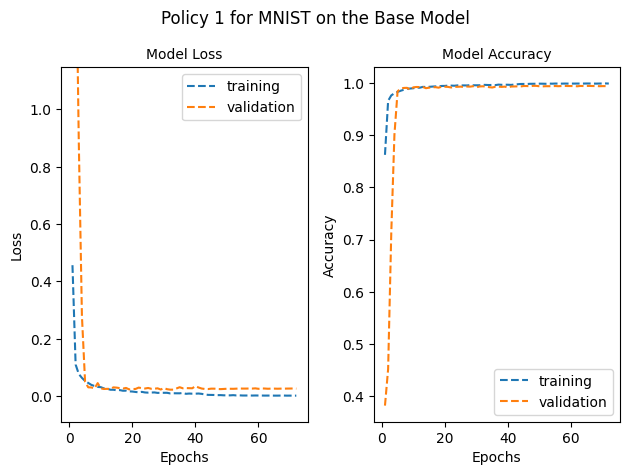

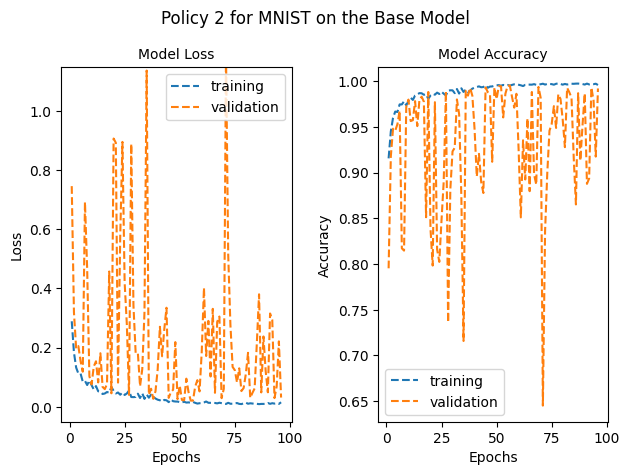

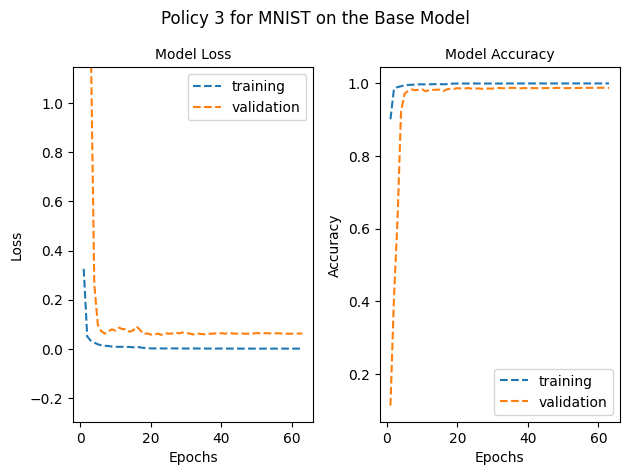

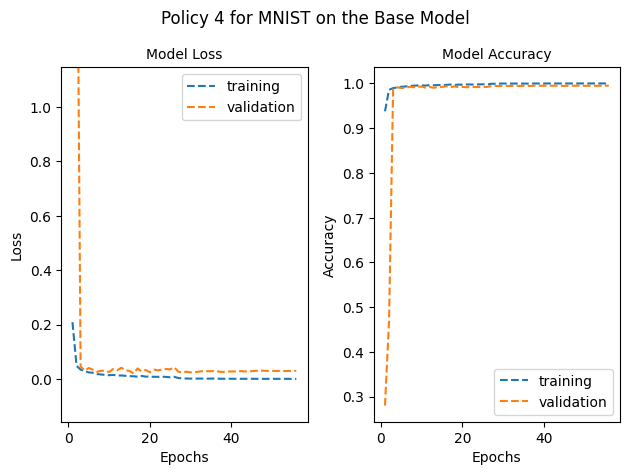

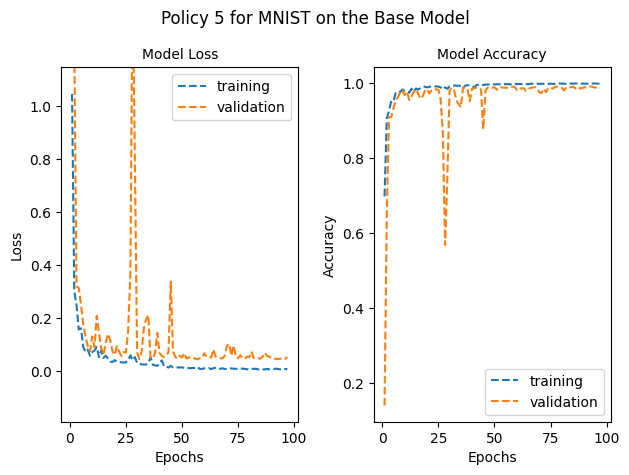

In [218]:
# Plot the history for each policy
for i, p in enumerate(policies):
    plot_history(p, i+1)

In [219]:
def plot_all_policies(policies):
    #epochs = range(1, len(policies[0].loss) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
    fig.suptitle(f"All policies for {DATASET_TITLE} on {NETWORK_TITLE}")
    ax1.set_title("Training Loss", fontsize=10)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax2.set_title("Validation Accuracy", fontsize=10)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    for i, p in enumerate(policies):
        epochs = range(1, len(p.loss) + 1)
        ax1.plot(epochs, p.loss, "--", label=f"policy {i+1}")
        ax2.plot(epochs, p.val_accuracy, label=f"policy {i+1}")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    plt.tight_layout()
    plt.savefig(FOLDER + "/{}_{}_all_policies_plot.png".format(DATASET, NETWORK))
    plt.show()
    plt.close()

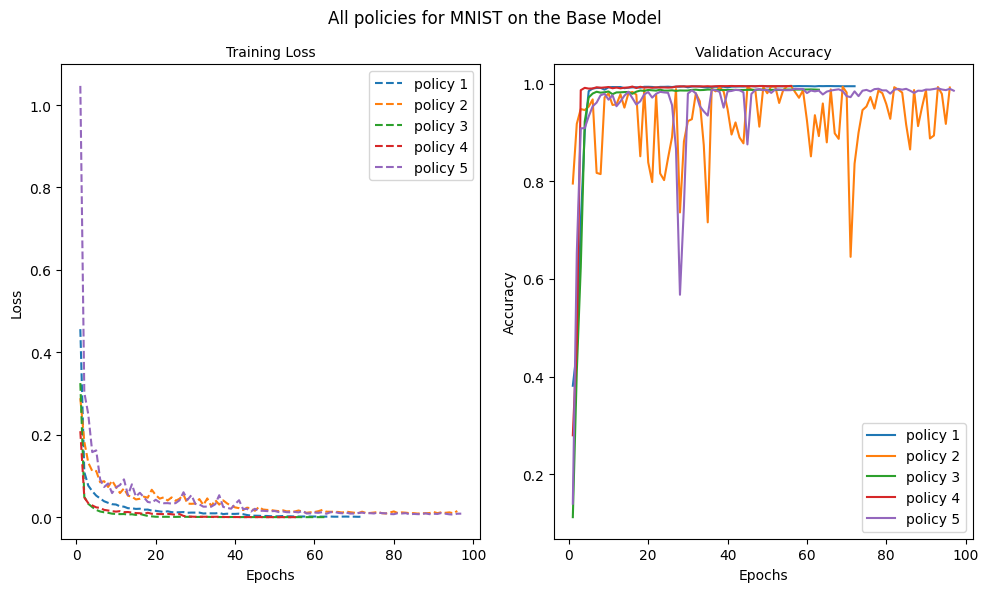

In [220]:
# plot history for all policies
plot_all_policies(policies)

### Latency
#### Training latency per policy

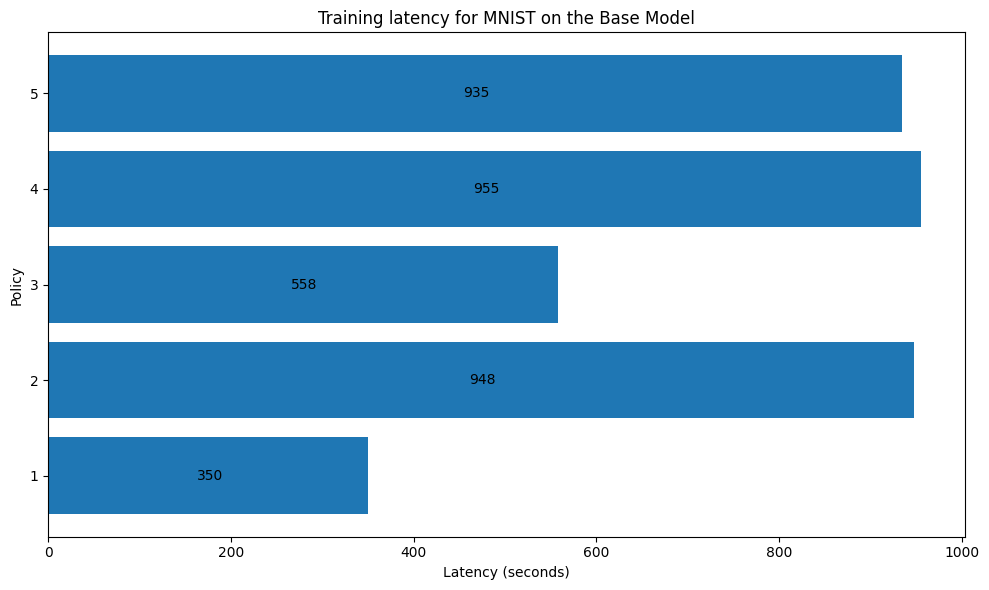

In [221]:
# plot latency for DATASET and NETWORK
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df.policy, df.latency)
ax.bar_label(bars, fmt="%.0f", padding=1, label_type="center")
ax.set_title(f"Training latency for {DATASET_TITLE} on {NETWORK_TITLE}")
ax.set_xlabel("Latency (seconds)")
ax.set_ylabel("Policy")
plt.tight_layout()
plt.show()

#### Total training latency

In [222]:
# get time delta from seconds
def get_time(num_seconds):
    h, m, s = str(datetime.timedelta(seconds=int(num_seconds))).split(':')
    return f'{h} hours, {m} minutes and {s} seconds'

In [223]:
# compute total training latency in hours, minutes and seconds
train_time = metrics.pivot_table(index='model', columns='dataset', values='latency', aggfunc='sum')

print("BASIC MODEL TRAINING TIME")
seconds = 0
for i in train_time.columns:
    seconds += train_time[i].basic
    time_delta = get_time(train_time[i].basic)
    print(f'{i}: {time_delta}')
print("Total train time: ", get_time(seconds))

print("\nINCEPTION TRAINING TIME")
seconds = 0
for i in train_time.columns:
    seconds += train_time[i].inception
    time_delta = get_time(train_time[i].inception)
    print(f'{i}: {time_delta}')
print("Total train time: ", get_time(seconds))

print("\nRESNET TRAINING TIME")
seconds = 0
for i in train_time.columns:
    seconds += train_time[i].resnet
    time_delta = get_time(train_time[i].resnet)
    print(f'{i}: {time_delta}')
print("Total train time: ", get_time(seconds))

BASIC MODEL TRAINING TIME
cifar10: 1 hours, 01 minutes and 20 seconds
fmnist: 0 hours, 41 minutes and 49 seconds
mnist: 1 hours, 02 minutes and 25 seconds
Total train time:  2 hours, 45 minutes and 35 seconds

INCEPTION TRAINING TIME
cifar10: 2 hours, 39 minutes and 00 seconds
fmnist: 2 hours, 58 minutes and 36 seconds
mnist: 3 hours, 24 minutes and 39 seconds
Total train time:  9 hours, 02 minutes and 17 seconds

RESNET TRAINING TIME
cifar10: 1 hours, 20 minutes and 02 seconds
fmnist: 1 hours, 28 minutes and 21 seconds
mnist: 1 hours, 45 minutes and 13 seconds
Total train time:  4 hours, 33 minutes and 37 seconds


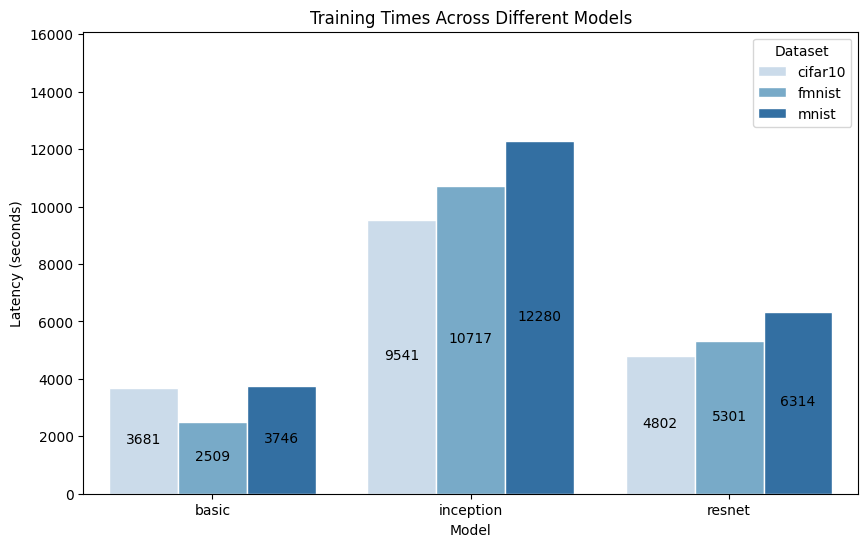

In [224]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'model',
            y = 'latency',
            hue = 'dataset',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            estimator=sum,
            edgecolor = "w")
ax.set_title("Training Times Across Different Models")
ax.set(xlabel='Model', ylabel='Latency (seconds)')
ax.legend(title="Dataset",loc='best')
for i in ax.containers:
    ax.bar_label(i,fmt="%.0f", padding=1,label_type='center')
plt.show()

#### Accuracy and F-1 Score

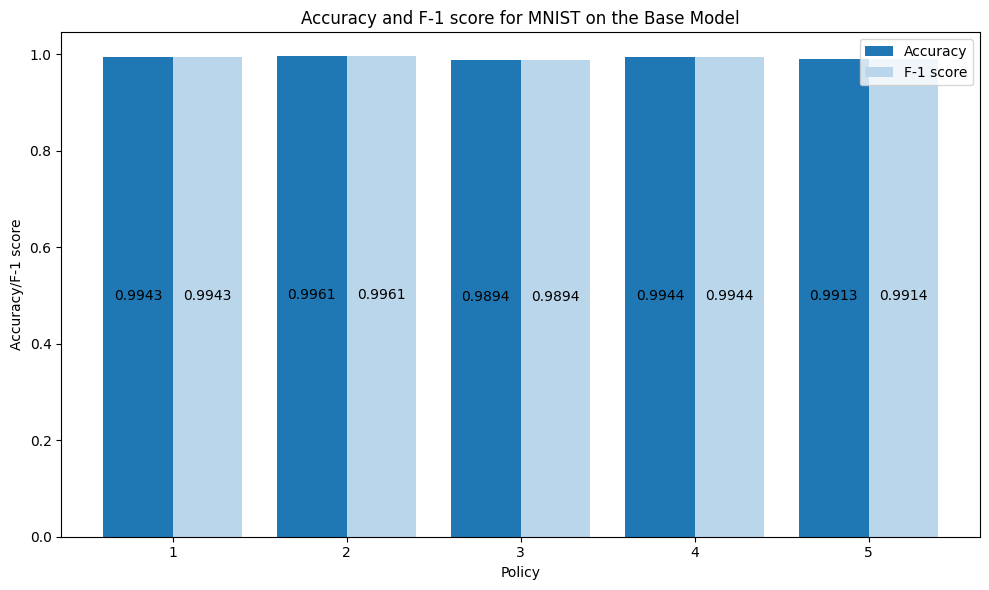

In [225]:
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(df.policy - 0.2, df.accuracy, 0.4, label = 'Accuracy')
bar2 = ax.bar(df.policy + 0.2, df.f1score, 0.4, label = 'F-1 score',color=sns.color_palette("Blues")[1])
ax.bar_label(bar1, fmt="%.4f", padding=1, label_type='center')
ax.bar_label(bar2, fmt="%.4f", padding=1, label_type='center')
ax.set_xlabel("Policy")
ax.set_ylabel("Accuracy/F-1 score")
ax.set_title(f"Accuracy and F-1 score for {DATASET_TITLE} on {NETWORK_TITLE}")
ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### Dataset Accuracy

In [226]:
#group metrics by highest accuracy
max_acc = metrics.groupby(['dataset','model'])['accuracy'].max().reset_index()
max_acc = max_acc.merge(metrics, on=['dataset','model','accuracy'])
max_acc

,dataset,model,accuracy,params,policy,precision,recall,f1score,latency
0,cifar10,basic,0.8895,1091594,2,0.891337,0.889500,0.890070,1076.573843
1,cifar10,inception,0.9134,21823274,2,0.914210,0.913400,0.913495,2912.677103
2,cifar10,resnet,0.8517,23585290,2,0.853505,0.851700,0.852275,1415.693934
3,fmnist,basic,0.9403,1091594,2,0.940406,0.940300,0.939848,970.569825
4,fmnist,inception,0.9482,21823274,2,0.948447,0.948200,0.948223,2471.100579
5,fmnist,resnet,0.9266,23585290,2,0.927923,0.926600,0.926928,1300.342571
6,mnist,basic,0.9961,1091594,2,0.996123,0.996065,0.996091,947.715536
7,mnist,inception,0.9958,21823274,2,0.995888,0.995740,0.995807,3200.916513
8,mnist,resnet,0.9937,23585290,2,0.993814,0.993635,0.993714,1391.577415


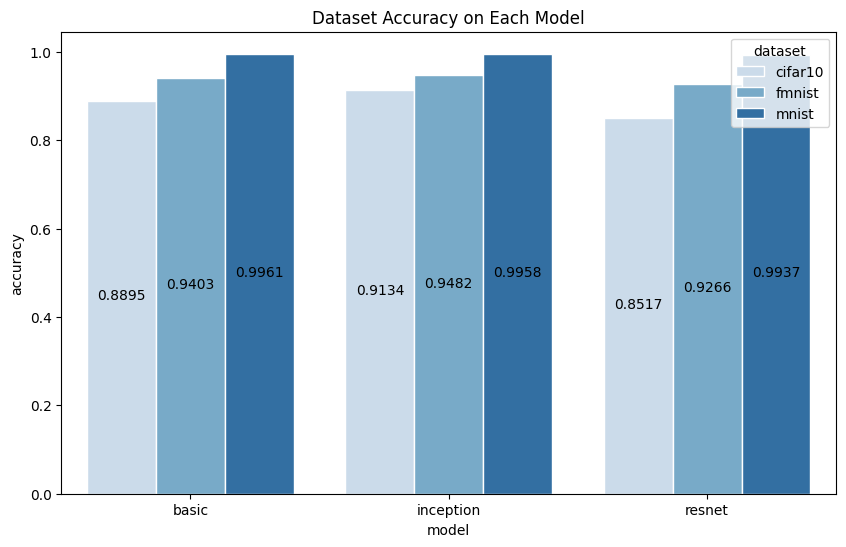

In [227]:
# show chart of highest accuracy for each dataset and model
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'model',
            y = 'accuracy',
            hue = 'dataset',
            data = max_acc,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Dataset Accuracy on Each Model")
for i in ax.containers:
    ax.bar_label(i,fmt="%.4f", padding=1,label_type='center')
plt.show()

#### Policy Accuracy on Dataset

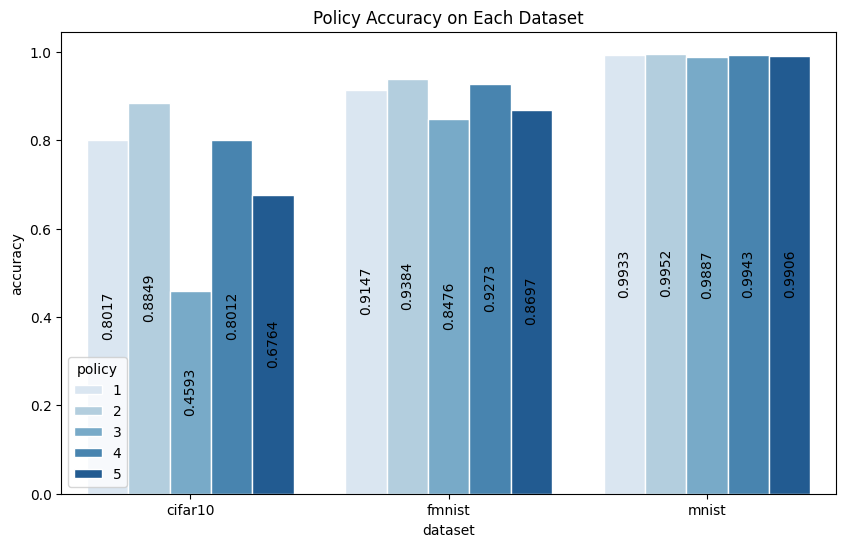

In [228]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'dataset',
            y = 'accuracy',
            hue = 'policy',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Policy Accuracy on Each Dataset")
for i in ax.containers:
    ax.bar_label(i,fmt="%.4f", padding=1,label_type='center',rotation=90)
plt.show()

#### Policy Accuracy on Model

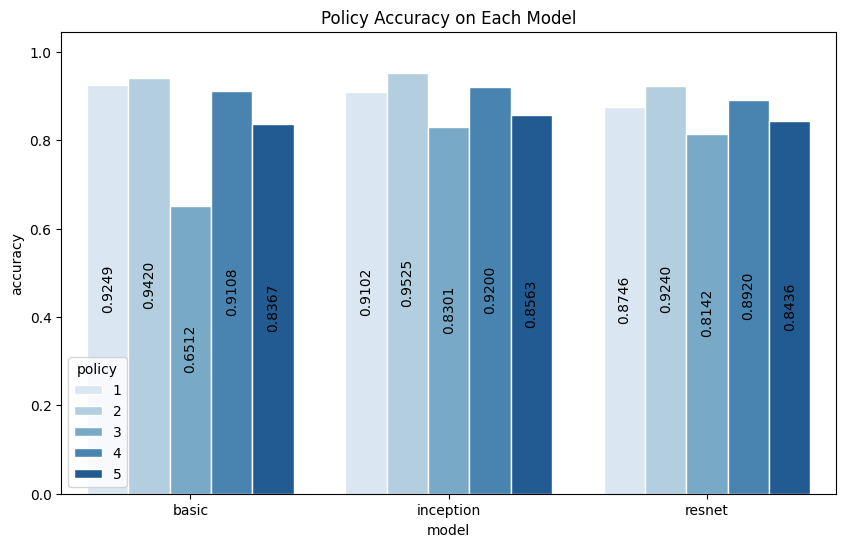

In [229]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'model',
            y = 'accuracy',
            hue = 'policy',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Policy Accuracy on Each Model")
for i in ax.containers:
    ax.bar_label(i,fmt="%.4f", padding=1, label_type='center',rotation=90)
plt.show()

#### Latency per Policy

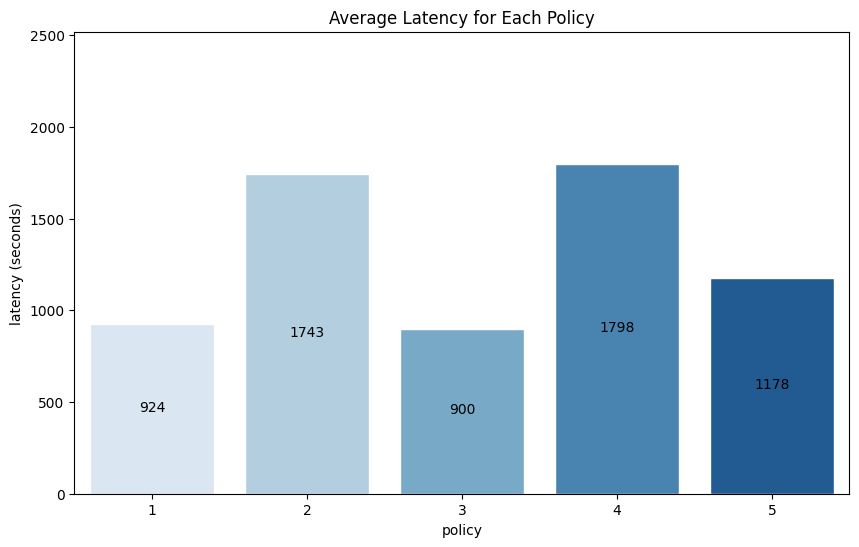

In [230]:
# Plot the average latency for each policy
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'policy',
            y = 'latency',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Average Latency for Each Policy")
ax.set(xlabel='policy', ylabel='latency (seconds)')
for i in ax.containers:
    ax.bar_label(i,fmt="%.0f", padding=1,label_type='center')
plt.show()

#### Accuracy based on number of parameters

In [231]:
param_stats = metrics.groupby(['model','params'])['accuracy'].describe()
param_stats = param_stats.drop(['count'],axis=1)
param_stats['mean'] = param_stats['mean'].round(4)
param_stats['std'] = param_stats['std'].round(4)
param_stats['min'] = param_stats['min'].round(4)
param_stats['max'] = param_stats['max'].round(4)
param_stats = param_stats.rename(columns={'50%': 'median'}).round(4)
param_stats = param_stats.reset_index()
param_stats

,model,params,mean,std,min,25%,median,75%,max
0,basic,1091594,0.8531,0.2286,0.1009,0.8575,0.9288,0.9904,0.9961
1,inception,21823274,0.8938,0.1089,0.6483,0.8410,0.9167,0.9902,0.9958
2,resnet,23585290,0.8697,0.1199,0.6286,0.7969,0.8985,0.9884,0.9937


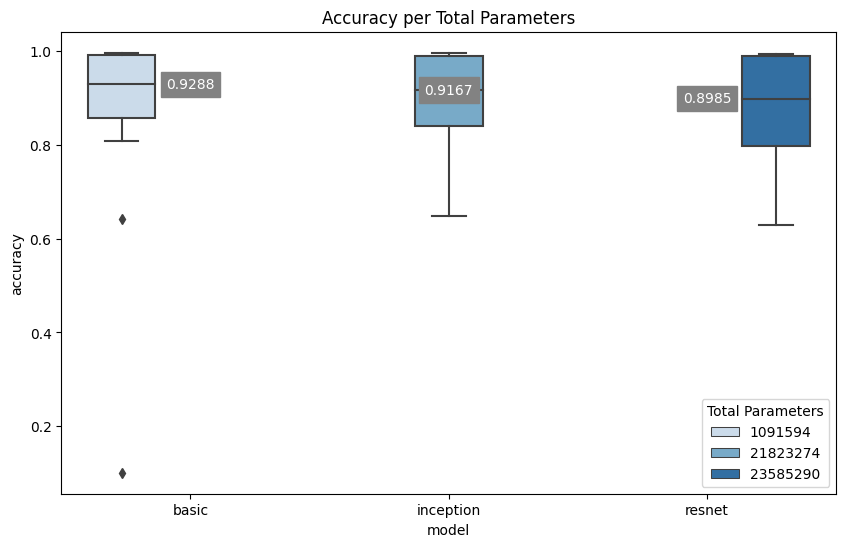

In [232]:
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.boxplot(x=metrics.model, y=metrics.accuracy, hue=metrics.params, data=metrics, palette="Blues")
ax.set_title("Accuracy per Total Parameters")
ax.set_xlabel("model")
ax.set_ylabel("accuracy")
ax.legend(title="Total Parameters",loc='best')

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = lines[4+cat*6].get_ydata()[0]
    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
    )

plt.show()